# Konwolucje

Dzięki uniwersalnemu twierdzeniu o aproksymacji dla sieci neuronowych, wiemy że sieci neuronowe składające się z warstw w pełni połączonych (perceptronów) może przybliżać dowolną funkcję ciągłą. Twierdzenie to nie daje nam sposobu na skontruowanie sieci neuronewej mogącej osiągnąć to zadanie w praktyce. Kedy dane wejściowe są obrazem, możemy skorzystać z pewnych założeń o tym jak powinna zachowywać się sieć neuronowa będąca w stanie rozpoznać obiekty znajdujące się na nim. Pomogą nam one znacznie ograniczyć ilość parametrów potrzebnych do jego przetworzenia, oraz uproszczą znacznie przestrzeń przeszukiwań dla Gradient Descentu.
W tym notatniku skupimy się na zadaniu klasyfikacji obrazków cyfr z MNISTA - zbioru czarno białych obrazków 32x32 przedstawiających ręcznie pisane cyfry.

[comment]: # (Tu fajnie byłoby przywołać MLP uczące się MNISTA - liczba parametrów tego a takiej konwolucyjnej)



In [27]:
#ładujemy dataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split

mnist = datasets.fetch_openml('mnist_784', version=1)
X, y = mnist.data.to_numpy(), mnist.target.astype(int)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42)

# Output the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (7000, 784)
y_train shape: (7000,)
X_test shape: (63000, 784)
y_test shape: (63000,)


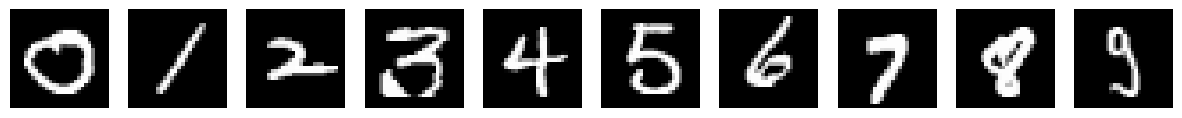

In [28]:
examples = {}

# Szukamy wystąpienia każdej z cyfr
for i in range(10):
    idx = np.where(y_train == i)[0][0]  # Get the index of the first occurrence of the number i
    examples[i] = X_train[idx].reshape(28, 28)

# Zobaczmy jak wyglądają sample z każdej z cyfr
fig, axs = plt.subplots(1, 10, figsize=(15, 1.5))

for i in range(10):
    axs[i].imshow(examples[i], cmap='gray')
    axs[i].axis('off')

plt.show()

plt.show()

Po pierwsze - jedynka pozostaje jedynką, niezależnie od tego czy znajduje się przy prawej czy lewej krawędzi obrazka - zatem chcemy aby wartość wyniku dla danego piksela była niezmiennicza na przesunięcia.
Po drugie - chcemy aby wpływ na wynik miało jedynie pewne otoczenie danego piksela - dla obrazków tak małych jak w MNIST może i nie ma to większego znaczenia - ale znów kot pozostaje kotem niezależnie od tego co znajduje się na reszcie zdjęcia.
[Okazuje się że te dwa warunki wystarczają aby ze standardowej w pełni połączonej warstwy otrzymać warstwę konowlucyjną](http://d2l.ai/chapter_convolutional-neural-networks/why-conv.html#)




## Co to konwolucja?

W pracy z obrazami korzystamy z 2-wymiarowych splotów, aby sąsadujące ze sobą piksele były
Najłatwiej zrozumieć działanie splotu przez obrazek poniżej. W trakcie obliczania macierz filtru (kernel) przesuwa się po pozycjach na których całość filtra mieści się w ramach obrazka, oraz w każdym miejscu mnoży punktowo wartości w swoich komórkach z odpowiadającymi im wartościami pikseli na obrazku i sumuje wynik.

![zdj1](img/iclh-diagram-convolutional-neural-networks.png)

Jeśli obrazek ma wymiary $n\times n$, a filtr $k\times k$, wynik będzie miał wymiar $(n-k+1)\times (n-k+1)$ ponieważ jest $n-k+1$ różnych sposobów na umieszczenie odcinka długości $k$ na odcinku długości $n$. Jeżeli chcemy, aby wymiary wyniku były równe wymiarom wejścia, możemy dodać padding - otoczyć obrazek odpowiednią ilością zer. Zobaczmy teraz implementacjię konwolucji w pythonie.

![gif1](img/kernel_vis.gif)

In [29]:
def convolve(img, kernel):
    image_height, image_width = img.shape
    filter_height, filter_width = kernel.shape
    #rozmiar wyjścia - ponieważ mnożymy tylko miejsca w których  kernel w pełni przecina się z obrazkiem
    output_height = image_height - filter_height + 1
    output_width = image_width - filter_width + 1
    output = np.zeros((output_height, output_width))
    for i in range(output_height):
        for j in range(output_width):
            #mnożymy punktowo kolejne legalne fragmenty obrazka przez nasz filtr (kernel) i sumujemy aby otrzymać wynik w miejscu (i,j)
            output[i, j] = np.sum(img[i:i+filter_height, j:j+filter_width] * kernel)
    return output

Oto przykładowe filtry używane w przetwarzaniu obrazów

In [30]:
verical_edge= np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])

horizontal_edge=verical_edge.T

sharpening = np.array([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
])
gaussian_blur = np.array([
    [1, 2, 1],
    [2, 4, 2],
    [1, 2, 1]
])

diagonal_edge1=np.array([
 [2,  1,  0],
 [1,  0, -1],
 [0, -1, -2]])

diagonal_edge2=np.array([
 [0,  1,  2],
 [-1,  0, 1],
 [-2, -1, 0]])

OnlyCrop=np.array([
 [0,  0,  0],
 [0,  1, 0],
 [0, 0, 0]])

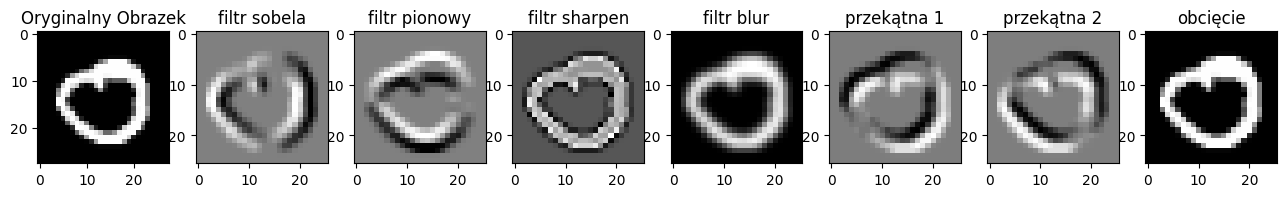

(28, 28)
(26, 26)


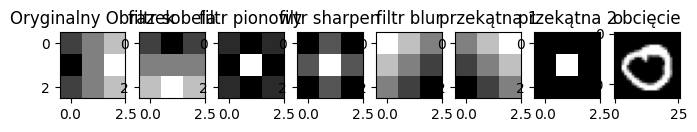

In [31]:
filters=[verical_edge,horizontal_edge,sharpening,diagonal_edge1,diagonal_edge2,OnlyCrop]

# konwolucje obrazka z naszymi filtrami
edges_detected = convolve(examples[0], verical_edge)
vedges_detected = convolve(examples[0], horizontal_edge)
sharpened_img= convolve(examples[0], sharpening)
blured_img= convolve(examples[0], gaussian_blur)
d1edges=convolve(examples[0],diagonal_edge1)
d2edges=convolve(examples[0],diagonal_edge2)
cut=convolve(examples[0],OnlyCrop)

#wyświetlamy obrazki
plt.figure(figsize=(16, 2))
plt.subplot(1, 8, 1)
plt.imshow(examples[0], cmap='gray')
plt.title('Oryginalny Obrazek')
plt.subplot(1, 8, 2)
plt.imshow(edges_detected, cmap='gray')
plt.title('filtr sobela')
plt.subplot(1, 8, 3)
plt.imshow(vedges_detected, cmap='gray')
plt.title('filtr pionowy')
plt.subplot(1, 8, 4)
plt.imshow(sharpened_img, cmap='gray')
plt.title('filtr sharpen')
plt.subplot(1, 8, 5)
plt.imshow(blured_img, cmap='gray')
plt.title('filtr blur')
plt.subplot(1, 8, 6)
plt.imshow(d1edges, cmap='gray')
plt.title('przekątna 1')
plt.subplot(1, 8, 7)
plt.imshow(d2edges, cmap='gray')
plt.title('przekątna 2')
plt.subplot(1, 8, 8)
plt.imshow(cut, cmap='gray')
plt.title('obcięcie')
plt.show()
print(examples[0].shape)
print(cut.shape)


#wyświetlamy filtry
plt.figure(figsize=(8, 1))
plt.subplot(1, 8, 1)
plt.imshow(verical_edge, cmap='gray')
plt.title('Oryginalny Obrazek')
plt.subplot(1, 8, 2)
plt.imshow(horizontal_edge, cmap='gray')
plt.title('filtr sobela')
plt.subplot(1, 8, 3)
plt.imshow(sharpening, cmap='gray')
plt.title('filtr pionowy')
plt.subplot(1, 8, 4)
plt.imshow(gaussian_blur, cmap='gray')
plt.title('filtr sharpen')
plt.subplot(1, 8, 5)
plt.imshow(diagonal_edge1, cmap='gray')
plt.title('filtr blur')
plt.subplot(1, 8, 6)
plt.imshow(diagonal_edge2, cmap='gray')
plt.title('przekątna 1')
plt.subplot(1, 8, 7)
plt.imshow(OnlyCrop, cmap='gray')
plt.title('przekątna 2')
plt.subplot(1, 8, 8)
plt.imshow(cut, cmap='gray')
plt.title('obcięcie')
plt.show()

In [32]:
#tu o paddingu

# Filtry dają feature'y
Spróbujemy teraz sklasyfikować odpowienio cyfry za pomocą regresji logistycznej.

In [33]:
from sklearn.linear_model import LogisticRegression

clf_simple = LogisticRegression(random_state=0, max_iter=100, verbose=True, n_jobs=6).fit(X_train, y_train)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         7850     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.30259D+00    |proj g|=  1.74589D+01


 This problem is unconstrained.



At iterate   50    f=  1.20393D-01    |proj g|=  5.02066D-01

At iterate  100    f=  1.42486D-02    |proj g|=  1.36395D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 7850    100    109      1     0     0   1.364D-01   1.425D-02
  F =   1.4248577169883649E-002

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/mm/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Jak widać, ponieważ MNIST jest łatwym datasetem, sama regresja osiąga dobry wynik. Ale możemy lepiej!

In [34]:
y_pred = clf_simple.predict(X_test)
print((y_test == y_pred).mean())

0.8690634920634921


# Filtry jako feature'y
Użyjemy teraz filtrów z wcześniejszego przykładu, aby wyciągnąć więcej informacji o strukturze naszych danych, dzięki czemu uzyskamy lepszy wynik

In [35]:
X_train_with_conv=X_train.reshape(-1,28, 28)
X_test_with_conv=X_test.reshape(-1,28, 28)
print(X_train_with_conv.shape)



(7000, 28, 28)


In [36]:
from scipy.signal import convolve2d

def apply_filters(X_train, filters):
    num_samples, height, width = X_train.shape
    num_filters = len(filters)
    output = np.zeros((num_samples, height - filters[0].shape[0] + 1, width - filters[0].shape[1] + 1, num_filters))

    for i in range(num_samples):
        for j, kernel in enumerate(filters):
            #można uruchomić to z naszą funkcją convolve, ale wbudowana funkcja będzie znacznie szybsza od działania na pythonowych tablicach
            #output[i, :, :, j] = convolve(X_train[i], kernel)
            output[i, :, :, j] = convolve2d(X_train[i], kernel, mode='valid')

    return output

# Apply filters to X_train
filtered_images = apply_filters(X_train_with_conv, filters)

# Output the shape of the filtered images array
print("Shape of filtered images:", filtered_images.shape)

Shape of filtered images: (7000, 26, 26, 6)


In [37]:
X_filtered=filtered_images.reshape(-1,26*26*len(filters))
clf_with_conv = LogisticRegression(random_state=0, max_iter=100, verbose=True, n_jobs=6).fit(X_filtered, y_train)


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        40570     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.30259D+00    |proj g|=  8.84379D+01


 This problem is unconstrained.



At iterate   50    f=  1.76886D-02    |proj g|=  3.17185D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
40570     83     89      1     0     0   7.900D-05   1.390D-05
  F =   1.3902617021144385E-005

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [38]:
Test_filtered=apply_filters(X_test_with_conv,filters)


In [39]:
print(Test_filtered.shape)
y_pred = clf_with_conv.predict(Test_filtered.reshape(-1,26*26*len(filters)))
print((y_test == y_pred).mean())

(63000, 26, 26, 6)
0.8594285714285714


Jak widać, wyciągnięcie feature'ów za pomocą naszych filtrów pomogło w wytrenowaniu regresji. Zauważmy że to co zaimplementowaliśmy jest w zasadzie siecią neuronową z jedną warstwą konwolucyjną, aktywacją f(x)=x oraz warstwą w pełni połączoną; z tym, że trenowaliśmy jedynie warstwę w pełni połączoną, a filtry wybraliśmy ręcznie. Przejdźmy więc do do kilkuwarstwowej sieci konwolucyjnej, która będzie uczyć się wartości filtrów podobnie jak warstwy połączonej

# Sieć neuronowa konwolucyjna dla mnista

# Inny sposób na wyciąganie feature'ów
teraz na mniscie to samo co na konkursie z patchami z kmeansow

In [40]:
PATCH_SIZE = 7
STRIDE = 7
patch_num = 7000*4
patches = []

for i in range(patch_num):
  for r in range(28-PATCH_SIZE+1):
    for c in range(28-PATCH_SIZE+1):
      patch = X_train_with_conv[i][c:(c+PATCH_SIZE),r:(r+PATCH_SIZE)]
      #print(patch.shape)
      #patch_norm = normalize_patch(patch, eps=10)
      patches.append(patch.flatten())
  if len(patches) >= patch_num:
    break

P = np.vstack(patches)
print(P.shape)

(28072, 49)


In [41]:
from sklearn.cluster import KMeans, MiniBatchKMeans
import numpy as np
k_root=8
k=64 #trochę jak 32 filtry w 1 warstwie sieci
kmeans = MiniBatchKMeans(n_clusters=k, random_state=0, verbose=True, n_init=1, max_iter=200, batch_size=7000).fit(P)
kmeans.labels_
kmeans.cluster_centers_
filters_final = kmeans.cluster_centers_
filters_final.shape


Init 1/1 with method k-means++
Inertia for init 1/1: 3222847988.0
[MiniBatchKMeans] Reassigning 1 cluster centers.
Minibatch step 1/802: mean batch inertia: 152924.59242857143
Minibatch step 2/802: mean batch inertia: 117755.14879414039, ewa inertia: 117755.14879414039
Minibatch step 3/802: mean batch inertia: 115758.3635159071, ewa inertia: 116759.35233863987
Minibatch step 4/802: mean batch inertia: 112847.07700428859, ewa inertia: 114808.30134013889
Minibatch step 5/802: mean batch inertia: 113260.33489212801, ewa inertia: 114036.33075373372
Minibatch step 6/802: mean batch inertia: 111113.20551915157, ewa inertia: 112578.56873028948
Minibatch step 7/802: mean batch inertia: 112921.3102005528, ewa inertia: 112749.49383924423
Minibatch step 8/802: mean batch inertia: 115782.2816862975, ewa inertia: 114261.9445876055
Minibatch step 9/802: mean batch inertia: 111002.20644463362, ewa inertia: 112636.3137678995
Minibatch step 10/802: mean batch inertia: 109365.3563947337, ewa inertia: 11

(64, 49)

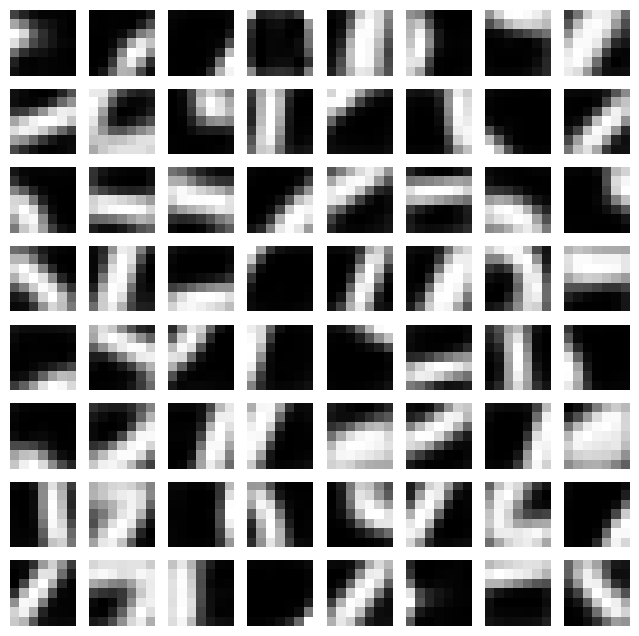

In [42]:
plt.figure(figsize=(k_root,k_root))
for xx in range(k):
    plt.subplot(k_root,k_root,xx+1)
    plt.imshow((filters_final[xx]).reshape(PATCH_SIZE, PATCH_SIZE), cmap=plt.get_cmap('gray'))
    plt.axis('off')


In [43]:
# użyjemy bibliotecznej implementacji konwolucji - jest szybsza
from scipy.signal import convolve2d

def apply_filters(X_train, filters):
    num_samples, height, width = X_train.shape
    num_filters = len(filters)
    output = np.zeros((num_samples, height - filters[0].shape[0] + 1, width - filters[0].shape[1] + 1, num_filters))

    for i in range(num_samples):
        for j, kernel in enumerate(filters):
            #można uruchomić to z naszą funkcją convolve, ale wbudowana funkcja będzie znacznie szybsza od działania na pythonowych tablicach
            output[i, :, :, j] = convolve2d(X_train[i], kernel, mode='valid')

    return output

k_means_filters=filters_final.reshape(-1,7,7)
# Apply filters to X_train
filtered_k_means = apply_filters(X_train_with_conv, k_means_filters)

# Output the shape of the filtered images array
print("Shape of filtered images:", filtered_k_means.shape)

Shape of filtered images: (7000, 22, 22, 64)


In [44]:
def test_results(inputs,filters,labels,data_size,batches=100):
    batch_size=int(data_size/batches)
    y_pred=[]
    print(inputs.shape)
    print(batch_size)
    for i in range(batches):
        filtered_batch=apply_filters(inputs[i*batch_size:(i+1)*batch_size,:,:],filters)
        y_pred.append(clf_with_conv.predict(filtered_batch.reshape(-1,22*22*len(k_means_filters))))
        print(f"batch {i} done")
    return y_pred

In [45]:
clf_with_conv = LogisticRegression(random_state=0, max_iter=100, verbose=True, n_jobs=6).fit(filtered_k_means.reshape(-1,22*22*len(k_means_filters)), y_train)


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       309770     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.30259D+00    |proj g|=  8.17246D+04


 This problem is unconstrained.



At iterate   50    f=  2.71377D-01    |proj g|=  1.67334D+03

At iterate  100    f=  2.25032D-01    |proj g|=  1.21389D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
*****    100    113      1     0     0   1.214D+03   2.250D-01
  F =  0.22503151518263120     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/mm/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [46]:
y_test_res=test_results(X_test_with_conv,k_means_filters,y_test,y_test.shape[0])

(63000, 28, 28)
630


batch 0 done
batch 1 done
batch 2 done
batch 3 done
batch 4 done
batch 5 done
batch 6 done


KeyboardInterrupt: 

In [ ]:
y_pred=np.concatenate(y_test_res,axis=0)
print((y_test == y_pred).mean())
#niesamowite, tu faktycznie pomogło, tylko jakim kosztem?

0.906079365079365


teraz jako feature'y użyjemy odległość euklidesową od naszych filtrów

In [ ]:
def dist(x,y):
  return np.sqrt((x - y).dot(x-y))
  #return (x-y).dot(x-y)
    
def create_patch_features(X):    
    X_mapped_list_per_image = []
    for i in range(X.shape[0]):
      if i % 1000 == 0:
        print(i,"/", X.shape[0])
        
      mapped_features = []
      for r in range(0, 28-PATCH_SIZE+1, STRIDE):
        for c in range(0, 28-PATCH_SIZE+1, STRIDE):
          patch = X[i].reshape(28,28)[c:(c+PATCH_SIZE),r:(r+PATCH_SIZE)].flatten()
          #patch_norm = normalize_patch(patch, eps=0.01)
          mapped_features.append([dist(patch, f) for f in filters_final])
      X_mapped_list_per_image.append(np.vstack(mapped_features))
    X_mapped = np.asarray(X_mapped_list_per_image).reshape(-1, ((32-PATCH_SIZE)//STRIDE+1)**2*filters_final.shape[0])
    return X_mapped

In [ ]:
from sklearn.feature_extraction import image
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import euclidean_distances

def create_patch_features__vectorized(X):    
    X_mapped_list_per_image = []
    for i in range(X.shape[0]):
        if i % 1000 == 0:
            print(i,"/", X.shape[0])
        patches = image.extract_patches_2d(X[i], (PATCH_SIZE, PATCH_SIZE))
        strided_patches = patches.reshape( 28-PATCH_SIZE+1 , 28-PATCH_SIZE+1, PATCH_SIZE, PATCH_SIZE)[::STRIDE,::STRIDE,:,:]
        strided_patches = strided_patches.reshape(((28-PATCH_SIZE)//STRIDE+1)**2, PATCH_SIZE * PATCH_SIZE)
        mapped_features = euclidean_distances(np.asarray([patch for patch in strided_patches]), filters_final)
        X_mapped_list_per_image.append(mapped_features.reshape(((28-PATCH_SIZE)//STRIDE+1)**2 * filters_final.shape[0]))
    X_mapped = np.asarray(X_mapped_list_per_image)
    return X_mapped

In [ ]:
X_mapped_train = create_patch_features(X_train)

0 / 7000
1000 / 7000
2000 / 7000
3000 / 7000
4000 / 7000
5000 / 7000
6000 / 7000


In [ ]:
#X_mapped_train = create_patch_features__vectorized(X_train)
print(X_mapped_train.shape)
#print(X_mapped_test.shape)

(7000, 1024)
(63000, 1024)


In [ ]:
X_mapped_train.shape
X_mapped_test=create_patch_features(X_test)

0 / 63000
1000 / 63000
2000 / 63000
3000 / 63000
4000 / 63000
5000 / 63000
6000 / 63000
7000 / 63000
8000 / 63000
9000 / 63000
10000 / 63000
11000 / 63000
12000 / 63000
13000 / 63000
14000 / 63000
15000 / 63000
16000 / 63000
17000 / 63000
18000 / 63000
19000 / 63000
20000 / 63000
21000 / 63000
22000 / 63000
23000 / 63000
24000 / 63000
25000 / 63000
26000 / 63000
27000 / 63000
28000 / 63000
29000 / 63000
30000 / 63000
31000 / 63000
32000 / 63000
33000 / 63000
34000 / 63000
35000 / 63000
36000 / 63000
37000 / 63000
38000 / 63000
39000 / 63000
40000 / 63000
41000 / 63000
42000 / 63000
43000 / 63000
44000 / 63000
45000 / 63000
46000 / 63000
47000 / 63000
48000 / 63000
49000 / 63000
50000 / 63000
51000 / 63000
52000 / 63000
53000 / 63000
54000 / 63000
55000 / 63000
56000 / 63000
57000 / 63000
58000 / 63000
59000 / 63000
60000 / 63000
61000 / 63000
62000 / 63000


In [ ]:
clf_mapped = LogisticRegression(random_state=0, max_iter=100, n_jobs=10, verbose=True).fit(X_mapped_train, y_train)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    7.9s finished


In [ ]:
print(X_mapped_test.shape)
y_pred = clf_mapped.predict(X_mapped_test)
print((y_test == y_pred).mean())

(63000, 1024)
0.9038730158730158


In [ ]:
#prawie taki sam wynik !